# CNN Example From Flowers by Keras (Color Version)


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import datasets, layers, models, regularizers,Model

from os import listdir
from os.path import isfile, join
import random
import warnings



import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam



IMG_W=224
IMG_H=224

In [2]:
def getFolder(thePath,isFile=True):
    return [f for f in listdir(thePath) if isFile == isfile(join(thePath, f)) ]


def getImagesAndLabels(tPath):
    labels=getFolder(tPath,False)
    encoder={w: i for i, w in enumerate(labels)}
    decoder={i: w  for i, w in enumerate(labels)}
    tImages,tLabels=None,None

    for label in labels:
        imgFolder=join(tPath,label)
        files= [f for f in listdir(imgFolder) if isfile(join(imgFolder, f))]
        for file in files:
            imageFile=join(imgFolder,file)
            img=plt.imread(imageFile)
            img = cv2.resize(img, (IMG_W,IMG_H))
            if tImages is None:
                tImages, tLabels =[img], np.array([encoder[label]],ndmin=1)
            else:
                tImages.append( img )
                tLabels = np.append(tLabels,np.array([encoder[label]]) ,axis=0) 
        print("finish=",label,"total=",len(tImages))
    return (tImages,tLabels,encoder,decoder,len(labels))

In [3]:
%%bash
x=$(dpkg -l|grep imagemagick);[ ${#x} -eq 0 ]&&sudo apt install -y imagemagick
[ ! -f ./flower_photos.tgz ]&&wget http://download.tensorflow.org/example_images/flower_photos.tgz ; tar xzf ./flower_photos.tgz 
find ./flower_photos|grep jpg|head -n 10|xargs -i -t identify {} 2>>/tmp/log

./flower_photos/daisy/5885826924_38fdc6bcaa_n.jpg JPEG 320x230 320x230+0+0 8-bit sRGB 34KB 0.000u 0:00.000
./flower_photos/daisy/12701063955_4840594ea6_n.jpg JPEG 320x240 320x240+0+0 8-bit sRGB 65.3KB 0.000u 0:00.000
./flower_photos/daisy/5997702776_c7bc37aa6b_n.jpg JPEG 320x213 320x213+0+0 8-bit sRGB 26KB 0.000u 0:00.000
./flower_photos/daisy/5673728_71b8cb57eb.jpg JPEG 500x332 500x332+0+0 8-bit sRGB 30.2KB 0.000u 0:00.000
./flower_photos/daisy/11834945233_a53b7a92ac_m.jpg JPEG 193x240 193x240+0+0 8-bit sRGB 21.5KB 0.000u 0:00.000
./flower_photos/daisy/9204730092_a7f2182347.jpg JPEG 500x332 500x332+0+0 8-bit sRGB 127KB 0.000u 0:00.000
./flower_photos/daisy/7066602021_2647457985_m.jpg JPEG 240x240 240x240+0+0 8-bit sRGB 40.7KB 0.000u 0:00.000
./flower_photos/daisy/43474673_7bb4465a86.jpg JPEG 500x375 500x375+0+0 8-bit sRGB 84.6KB 0.000u 0:00.000
./flower_photos/daisy/5876455546_32049e5585.jpg JPEG 500x333 500x333+0+0 8-bit sRGB 71.8KB 0.000u 0:00.000
./flower_photos/daisy/512177035_70a

In [4]:
from sklearn.model_selection import train_test_split
basePath='./flower_photos'
imgs,labels,encoder,decoder,class_cnt=getImagesAndLabels(basePath)


finish= daisy total= 633
finish= tulips total= 1432
finish= dandelion total= 2330
finish= roses total= 2971
finish= sunflowers total= 3670


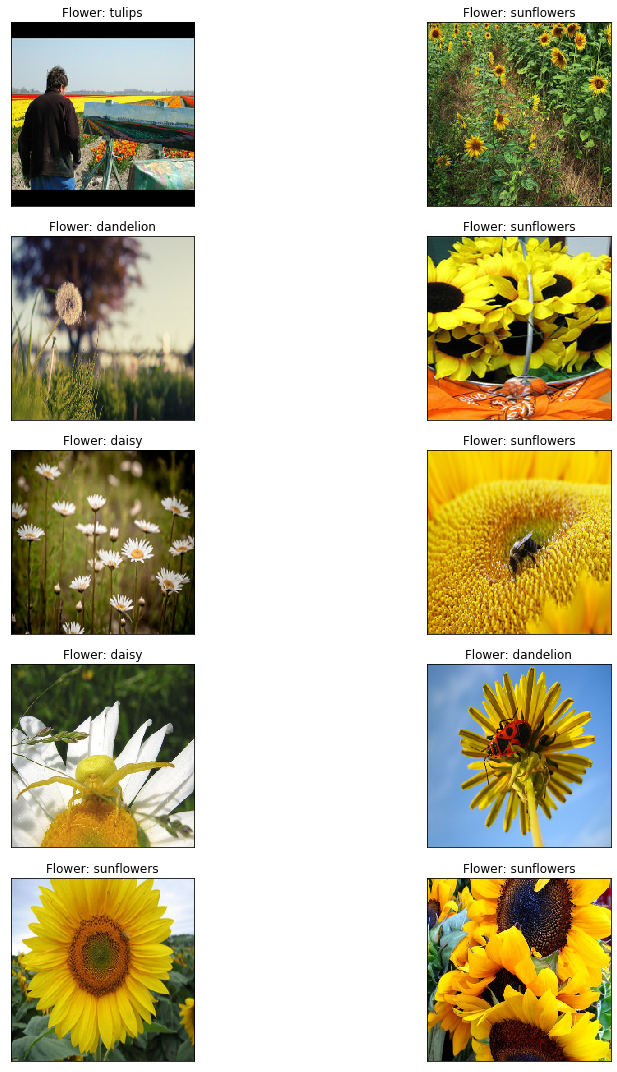

In [6]:
count=0
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range (5):
    for j in range (2):
        l=random.randint(0,len(imgs))
        ax[i,j].imshow(imgs[l])
        ax[i,j].set_title('Flower: '+ decoder[labels[l]])
        ax[i,j].grid(False)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        count+=1
plt.tight_layout()


In [7]:
le=LabelEncoder()
labels=np.array(labels)

Y=le.fit_transform(labels)
Y=to_categorical(Y,class_cnt)
imgs=np.array(imgs)

In [8]:
train_images,test_images,train_labels,test_labels=train_test_split(imgs,labels,test_size=0.25, random_state=88)


In [9]:
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

In [10]:
from tensorflow.python.keras.applications.vgg16 import VGG16

model=models.Sequential()
model.add(VGG16(weights='imagenet'))
# model.summary()

inp=layers.Input(shape=(224,224,3))
out=VGG16(weights='imagenet')(inp)
model=Model(inputs=inp,outputs=out)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 1000)              138357544 
Total params: 138,357,544
Trainable params: 138,357,544
Non-trainable params: 0
_________________________________________________________________


In [11]:
History=model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=1,batch_size=10)

Train on 2752 samples
2752/2752 [==============================] - 70s 26ms/sample - loss: 2.5427 - acc: 0.3365


In [12]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.352180517057448
Test accuracy: 0.40087146


In [13]:
# getting predictions on val set.
pred=model.predict(test_images)
pred_digits=np.argmax(pred,axis=1)

In [26]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(test_labels)):
    if(np.argmax(test_labels[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(test_labels)):

    if( test_labels[i] != pred_digits[i]):
        print(test_labels[i],pred_digits[i])        
        mis_class.append(i)
    if(len(mis_class)==8):
        break

0 2
3 0
0 2
3 0
0 3
4 0
1 3
2 0


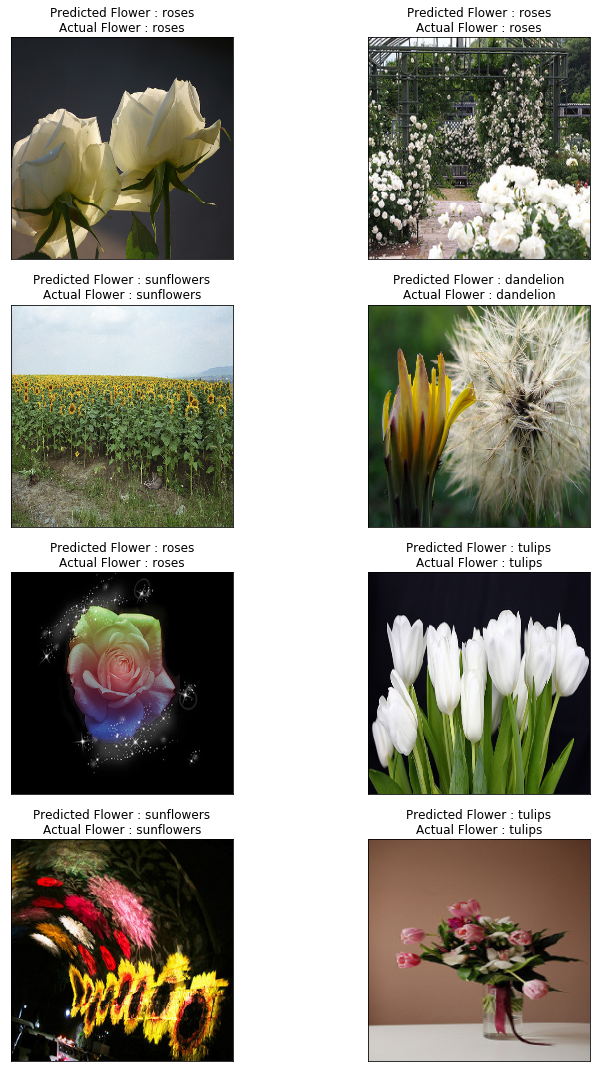

In [27]:

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        img=test_images[prop_class[count]]
        ax[i,j].imshow(img)
        ax[i,j].set_title("Predicted Flower : "+ decoder[test_labels[prop_class[count      ]]] +"\n"+ \
                          "Actual Flower : "   + decoder[test_labels[prop_class[count      ]]])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        plt.tight_layout()
        count+=1

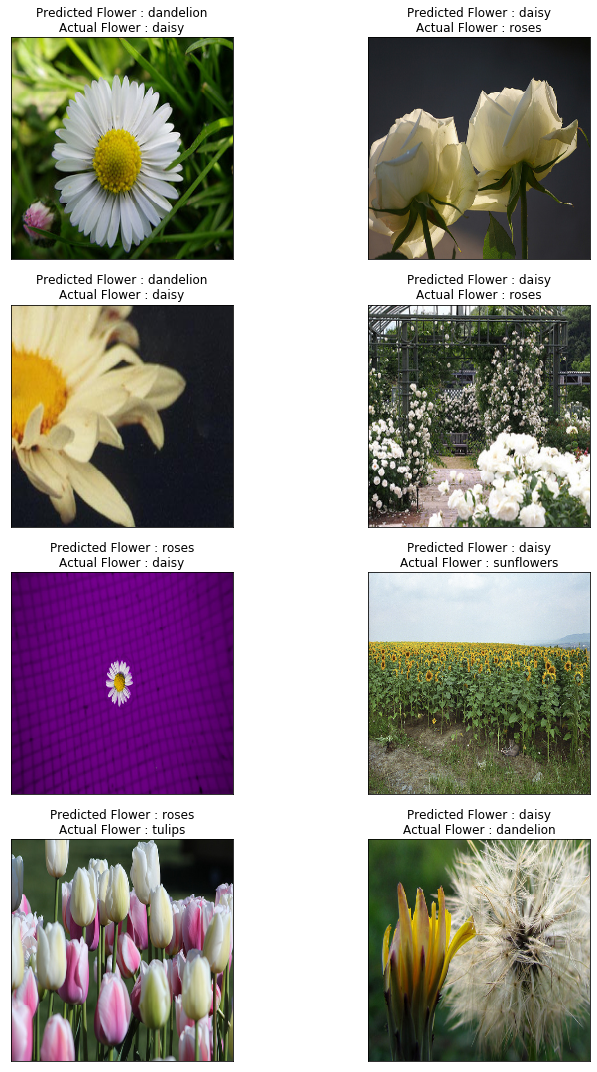

In [28]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        img=test_images[mis_class[count]]
        ax[i,j].imshow(img)
        ax[i,j].set_title("Predicted Flower : "+ decoder[pred_digits[mis_class[count]]] +"\n"+ \
                          "Actual Flower : "   + decoder[test_labels[mis_class[count]]])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        plt.tight_layout()
        count+=1
